# Importing Libraries and Modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [2]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Images

Tautan Dataset Kaggle: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset/data

In [4]:
import zipfile
import os

# Tentukan path ke file zip
zip_file_path = '/content/drive/MyDrive/DATASET/archive.zip'

# Tentukan path tempat dataset akan diekstrak
extracted_folder_path = '/content'

# Mengekstrak file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Menampilkan daftar file setelah diekstrak
extracted_files = os.listdir(extracted_folder_path)
print("Dataset berhasil diekstrak:")
print(extracted_files)


Dataset berhasil diekstrak:
['.config', 'data', 'drive', 'sample_data']


In [ ]:
# Pre-Processing Dataset

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
print(class_names)
print(f"Total batches in dataset: {len(dataset)}")

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
Total batches in dataset: 131


In [7]:
len(dataset)

131

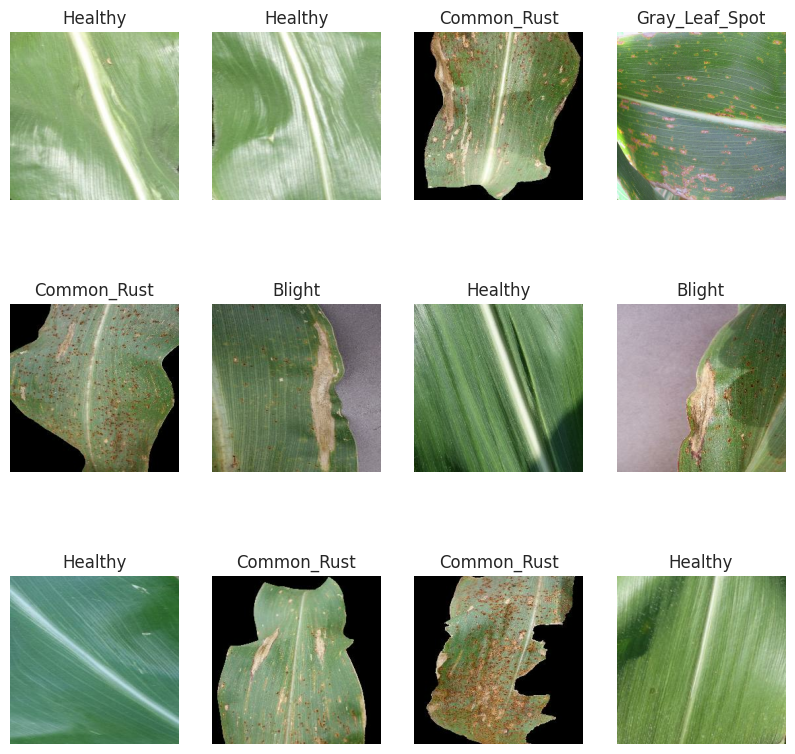

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Train-test Split

In [9]:
def get_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [11]:
print(f"Length of Training Dataset: {len(train_ds)}")
print(f"Length of Validation Dataset: {len(val_ds)}")
print(f"Length of Testing Dataset: {len(test_ds)}")

Length of Training Dataset: 104
Length of Validation Dataset: 13
Length of Testing Dataset: 14


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

# Model Building

In [14]:
n_classes = 4
input_shape = (256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, *input_shape))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Fitting

In [17]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

Epoch 1/20
104/104 [==============================] - 34s 178ms/step - loss: 0.9800 - accuracy: 0.5310 - val_loss: 0.8175 - val_accuracy: 0.5625
Epoch 2/20
104/104 [==============================] - 6s 58ms/step - loss: 0.8202 - accuracy: 0.6092 - val_loss: 0.6852 - val_accuracy: 0.7067
Epoch 3/20
104/104 [==============================] - 6s 56ms/step - loss: 0.5712 - accuracy: 0.7732 - val_loss: 0.4006 - val_accuracy: 0.8606
Epoch 4/20
104/104 [==============================] - 6s 56ms/step - loss: 0.3742 - accuracy: 0.8454 - val_loss: 0.4312 - val_accuracy: 0.8005
Epoch 5/20
104/104 [==============================] - 6s 58ms/step - loss: 0.3653 - accuracy: 0.8427 - val_loss: 0.2769 - val_accuracy: 0.8966
Epoch 6/20
104/104 [==============================] - 6s 57ms/step - loss: 0.3032 - accuracy: 0.8646 - val_loss: 0.3623 - val_accuracy: 0.8702
Epoch 7/20
104/104 [==============================] - 6s 57ms/step - loss: 0.2885 - accuracy: 0.8782 - val_loss: 0.2317 - val_accuracy: 0.91

# Model Evaluation

In [18]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 10s 35ms/step - loss: 0.2089 - accuracy: 0.9375


In [19]:
print(f"Test accuracy: {scores[1] * 100:.2f}%")

Test accuracy: 93.75%


# Plotting Loss and Accuracy

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

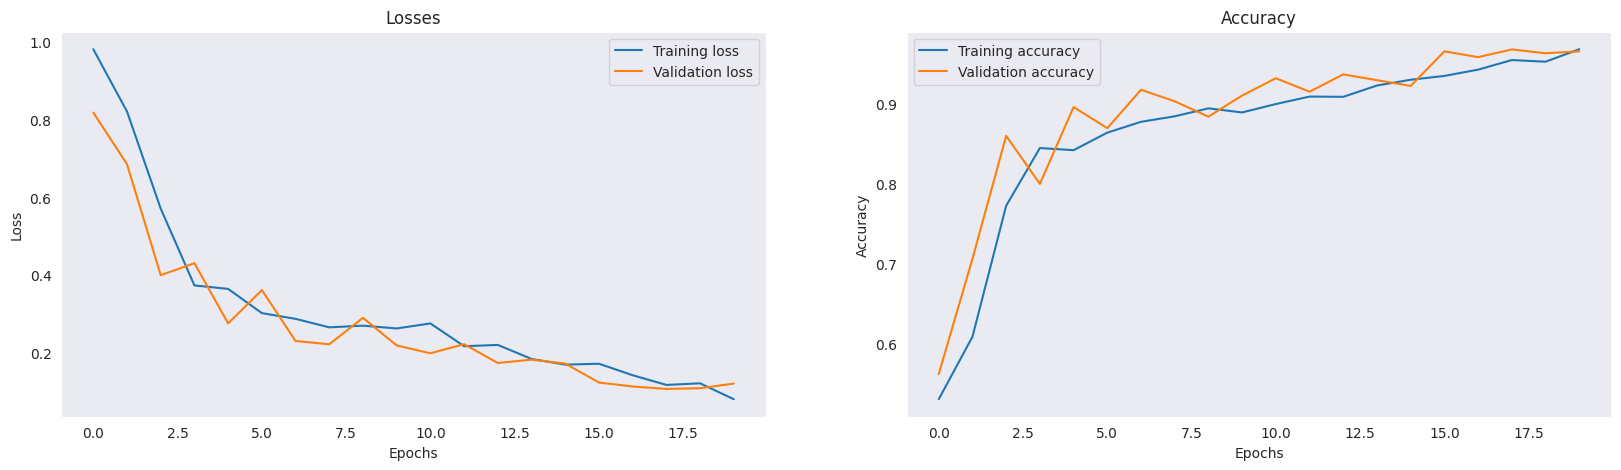

In [21]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(his_data['loss'], label="Training loss")
plt.plot(his_data['val_loss'], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(his_data['accuracy'], label="Training accuracy")
plt.plot(his_data['val_accuracy'], label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# Prediction

First Image to Predict:

Actual label: Healthy
1/1 [==============================] - 0s 276ms/step

Predicted label: Healthy


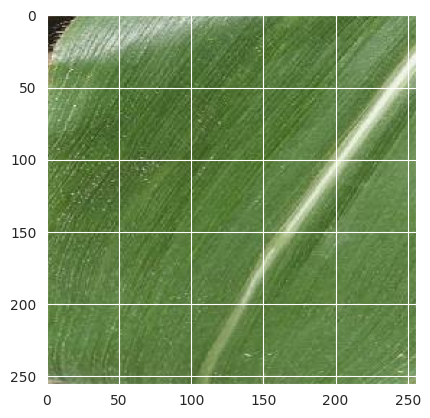

In [22]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict:")
    plt.imshow(first_image)
    print("\nActual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("\nPredicted label:", class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


1/1 [==============================] - 0s 17ms/step


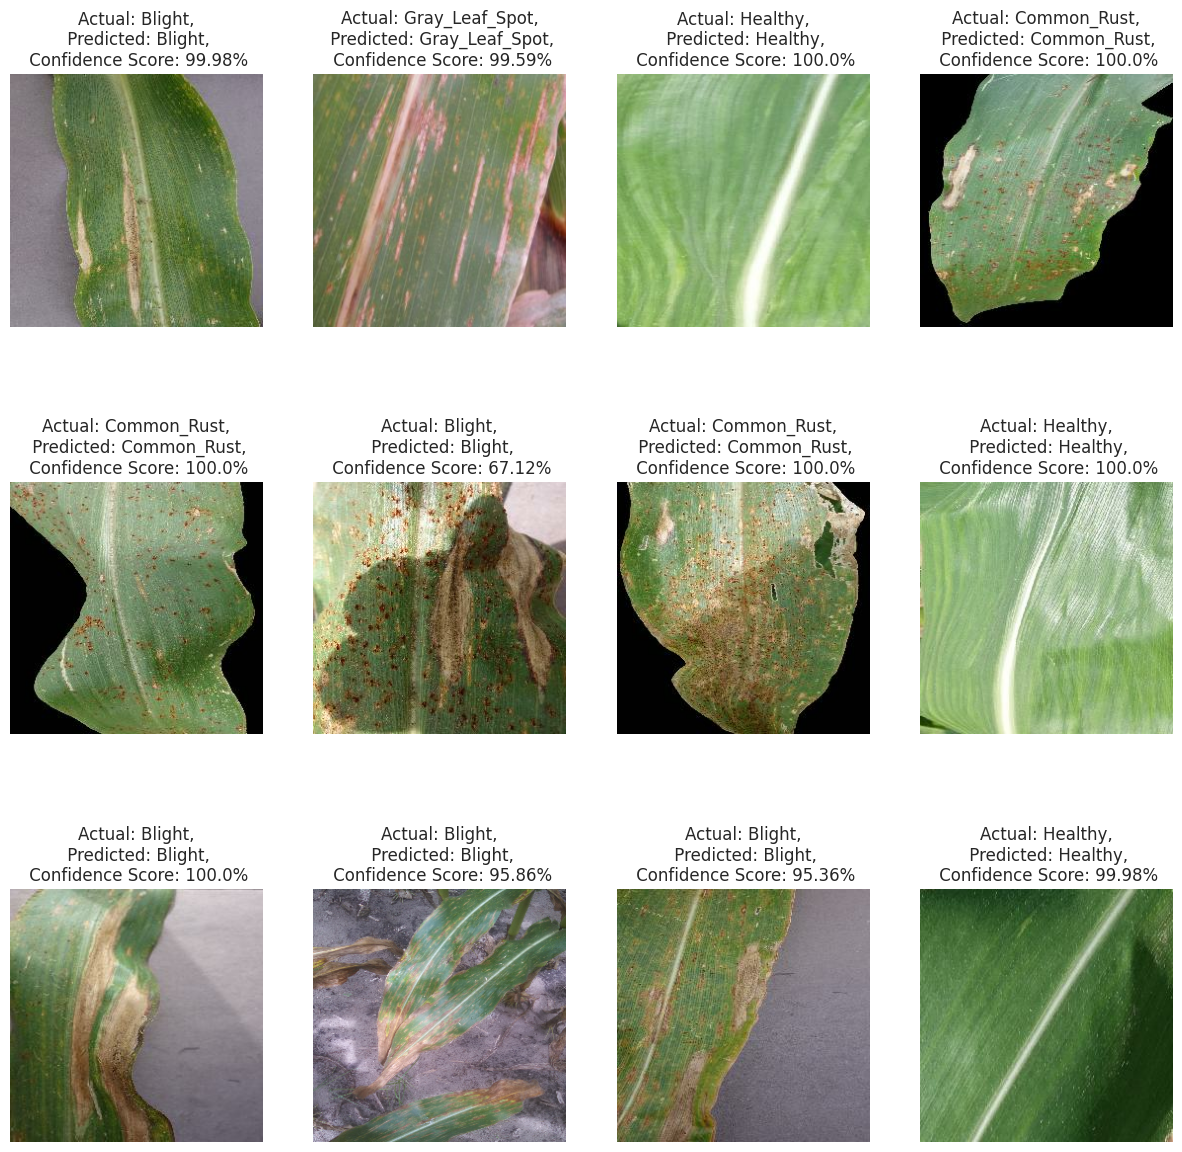

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

# Save Model

In [25]:
model.save('/content/corn disease classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
model.save('/content/model')